In [6]:
from qiskit import BasicAer, execute
from time import time
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from pprint import pprint
import pixiedust
from quantum_logic_operation import quantum_adder

In [7]:
multiplier_fir_qbit = 3
multiplier_sec_qbit = 2
treg_qbit = min(multiplier_fir_qbit, multiplier_sec_qbit)
res_qbit = multiplier_fir_qbit + multiplier_sec_qbit
assist_qbit = 2
all_qbit = multiplier_sec_qbit + multiplier_fir_qbit + treg_qbit+res_qbit+assist_qbit
q_fir = QuantumRegister(multiplier_fir_qbit, 'fir')
q_sec = QuantumRegister(multiplier_sec_qbit, 'sec')
q_treg = QuantumRegister(treg_qbit, 'treg')
q_res = QuantumRegister(res_qbit, 'res')
q_ass = QuantumRegister(assist_qbit, 'ass')
circuit = QuantumCircuit()
cr = ClassicalRegister(all_qbit, 'cr')

circuit.add_register(q_fir)
circuit.add_register(q_sec)
circuit.add_register(q_treg)
circuit.add_register(q_res)
circuit.add_register(q_ass)
all_component_lst = [q_fir, q_sec, q_treg, q_res, q_ass]
qbit_lst = []
for _ in all_component_lst:
    for i in range(_.size):
        qbit_lst.append(_[i])
pprint(qbit_lst)

[(QuantumRegister(3, 'fir'), 0),
 (QuantumRegister(3, 'fir'), 1),
 (QuantumRegister(3, 'fir'), 2),
 (QuantumRegister(2, 'sec'), 0),
 (QuantumRegister(2, 'sec'), 1),
 (QuantumRegister(2, 'treg'), 0),
 (QuantumRegister(2, 'treg'), 1),
 (QuantumRegister(5, 'res'), 0),
 (QuantumRegister(5, 'res'), 1),
 (QuantumRegister(5, 'res'), 2),
 (QuantumRegister(5, 'res'), 3),
 (QuantumRegister(5, 'res'), 4),
 (QuantumRegister(2, 'ass'), 0),
 (QuantumRegister(2, 'ass'), 1)]


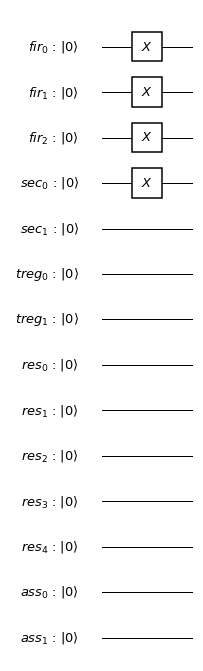

In [8]:
circuit.x(qbit_lst[0])
circuit.x(qbit_lst[1])
circuit.x(qbit_lst[2])
circuit.x(qbit_lst[3])
circuit.draw(output='mpl')

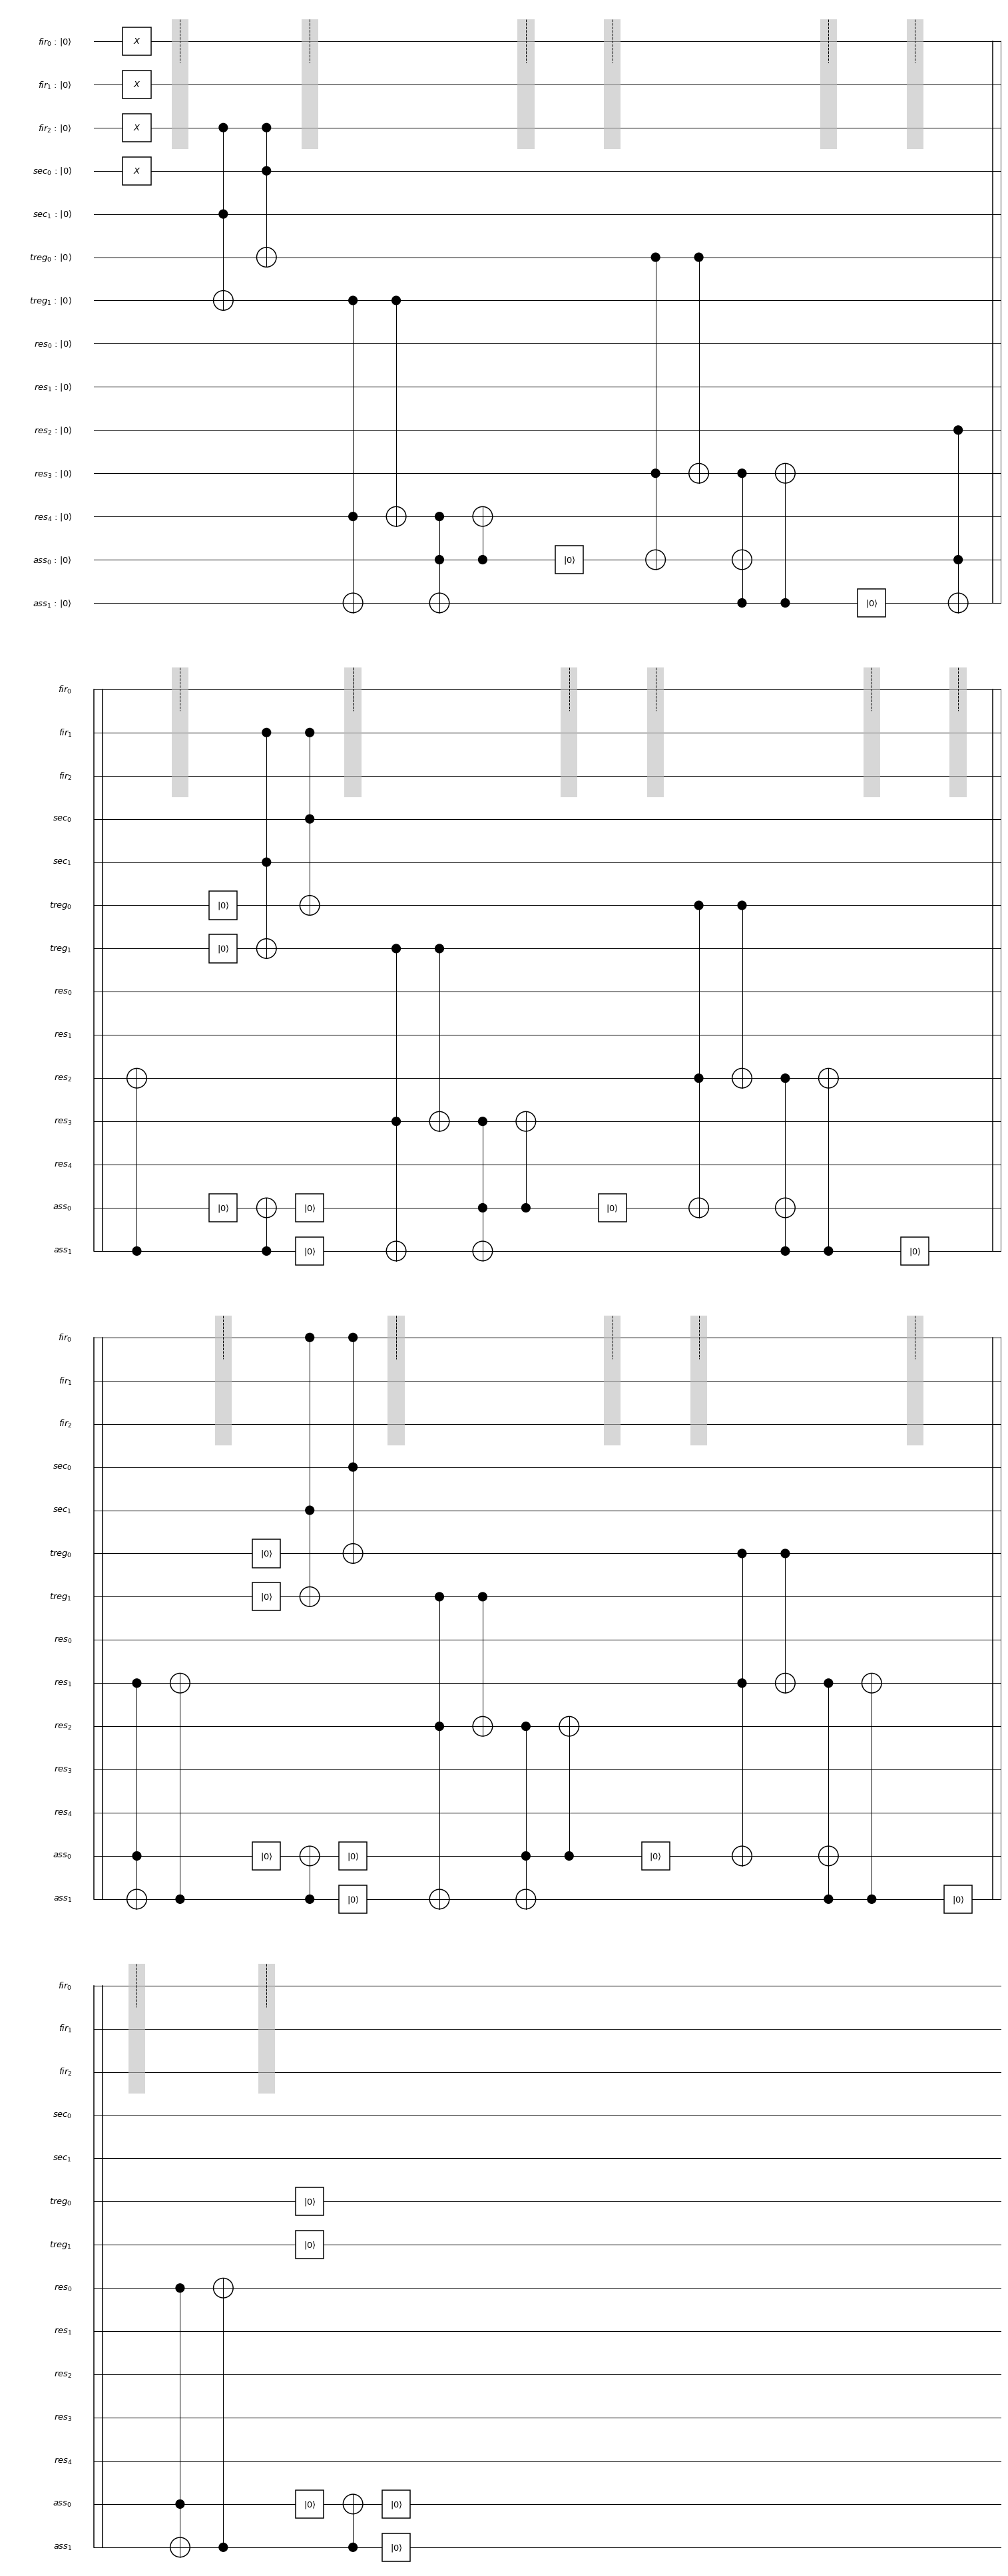

In [9]:
# %%pixie_debugger
circuit.barrier()
res_idx=multiplier_fir_qbit+multiplier_sec_qbit+treg_qbit+res_qbit
for i in range(multiplier_fir_qbit - 1, -1, -1):
    treg_cur = multiplier_fir_qbit + multiplier_sec_qbit + treg_qbit - 1
    treg_reset_lst=[]
    for _ in range(multiplier_fir_qbit + multiplier_sec_qbit - 1,
                   multiplier_fir_qbit - 1, -1):
        circuit.ccx(qbit_lst[i], qbit_lst[_], qbit_lst[treg_cur])
        treg_reset_lst.append(treg_cur)
        treg_cur -= 1
    circuit.barrier()
#     得到需要相加的量子比特列表
    adder_qbit_lst=qbit_lst[res_idx-treg_qbit-1:res_idx]
    treg_idx=multiplier_fir_qbit+multiplier_sec_qbit
    adder_qbit_lst+=qbit_lst[treg_idx:treg_idx+treg_qbit]
    adder_qbit_lst+=qbit_lst[-2::]
    circuit.barrier()
    quantum_adder(circuit, adder_qbit_lst, treg_qbit+1,treg_qbit)
    res_idx-=1
    for _ in treg_reset_lst:
        circuit.reset(qbit_lst[_])
    circuit.reset(qbit_lst[-2])
circuit.draw(output='mpl',scale=1)

In [10]:
circuit.add_register(cr)
for _ in range(all_qbit):
    circuit.measure(qbit_lst[_],cr[_])
backend=BasicAer.get_backend('qasm_simulator')
result=execute(circuit,backend,shots=1).result()
counts=result.get_counts(circuit)
all_lst=list(counts.keys())
print(all_lst)

['00011100001111']
